In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 59 kB 4.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
from transformers import AdamW

TRAIN_DIR = '/content/drive/MyDrive/TRAIN'
TEST_DIR = '/content/drive/MyDrive/TEST'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.hub.list('rwightman/pytorch-dpn-pretrained')

Downloading: "https://github.com/rwightman/pytorch-dpn-pretrained/archive/master.zip" to /root/.cache/torch/hub/master.zip


['dpn107', 'dpn131', 'dpn68', 'dpn68b', 'dpn92', 'dpn98']

In [4]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn131', pretrained=True)

Using cache found in /root/.cache/torch/hub/rwightman_pytorch-dpn-pretrained_master
Downloading: "https://github.com/rwightman/pytorch-dpn-pretrained/releases/download/v0.1/dpn131-71dfe43e0.pth" to /root/.cache/torch/hub/checkpoints/dpn131-71dfe43e0.pth


  0%|          | 0.00/303M [00:00<?, ?B/s]

In [ ]:
model

In [6]:
model.classifier = nn.Conv2d(2688, 32, kernel_size=(1,1), stride=(1,1))
model = model.to(device)

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = dsets.ImageFolder(TRAIN_DIR, transform=transform)
test_data = dsets.ImageFolder(TEST_DIR, transform=transform)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
t_accs, v_accs, t_loss, v_loss = [], [], [], []
epochs=50
criterion = nn.CrossEntropyLoss().cuda()
optimizer = AdamW(model.parameters(), lr=1e-5)

for epoch in range(epochs):
  train_loss = 0
  train_accuracy = 0
  model.train()

  for images, labels in trainloader:
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    output = model(images)
    ps = torch.exp(output) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  
  t_accs.append(train_accuracy/len(trainloader))
  t_loss.append(train_loss/len(trainloader))

  test_loss = 0
  test_accuracy = 0
  model.eval()

  for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    log_ps = model(images)
    test_loss += criterion(log_ps, labels).item()

    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))
  
  v_accs.append(test_accuracy/len(testloader))
  v_loss.append(test_loss/len(testloader))

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}".format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

  model_out_path = '.model.pth'
  torch.save(model.state_dict(), model_out_path)


==> Epoch[1/50]
loss: 2.876, Accuracy: 0.327, val_loss: 1.937, val_accuracy: 0.622
==> Epoch[2/50]
loss: 1.274, Accuracy: 0.784, val_loss: 0.800, val_accuracy: 0.872
==> Epoch[3/50]
loss: 0.528, Accuracy: 0.928, val_loss: 0.453, val_accuracy: 0.906
==> Epoch[4/50]
loss: 0.249, Accuracy: 0.959, val_loss: 0.330, val_accuracy: 0.913
==> Epoch[5/50]
loss: 0.146, Accuracy: 0.971, val_loss: 0.281, val_accuracy: 0.916
==> Epoch[6/50]
loss: 0.108, Accuracy: 0.974, val_loss: 0.264, val_accuracy: 0.916
==> Epoch[7/50]
loss: 0.076, Accuracy: 0.975, val_loss: 0.245, val_accuracy: 0.919
==> Epoch[8/50]
loss: 0.073, Accuracy: 0.979, val_loss: 0.253, val_accuracy: 0.922
==> Epoch[9/50]
loss: 0.061, Accuracy: 0.980, val_loss: 0.249, val_accuracy: 0.919
==> Epoch[10/50]
loss: 0.054, Accuracy: 0.976, val_loss: 0.236, val_accuracy: 0.922
==> Epoch[11/50]
loss: 0.052, Accuracy: 0.978, val_loss: 0.251, val_accuracy: 0.919
==> Epoch[12/50]
loss: 0.048, Accuracy: 0.978, val_loss: 0.241, val_accuracy: 0.919
=

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
torch.save(model, '/content/drive/MyDrive/harrypotter_DPN131_Epoch50.h5')

In [15]:
momodel = torch.load('/content/drive/MyDrive/harrypotter_DPN131_Epoch50.h5')

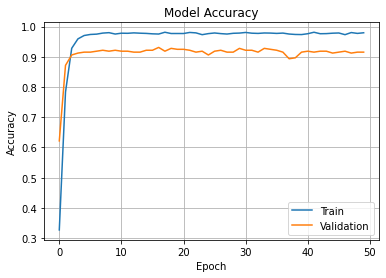

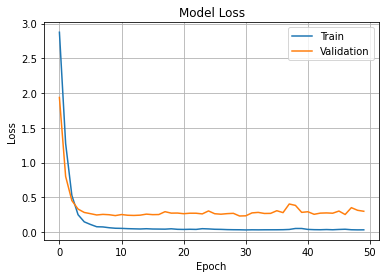

In [16]:
import matplotlib.pyplot as plt

plt.title('Model Accuracy')
plt.plot(t_accs, label= "Training Accuracy") 
plt.plot(v_accs, label= "Validation Accuracy") 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

plt.title('Model Loss')
plt.plot(t_loss, label = "Training loss") 
plt.plot(v_loss, label = "Validation loss") 
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

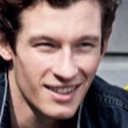

tensor(31)


In [20]:
tst = '/content/drive/MyDrive/TEST/31/000077.jpg'
img = cv2.imread(tst)
cv2_imshow(img)
trans_img = transform(img)
trans_img = Variable(trans_img)
ti = trans_img.unsqueeze(0)
ti = ti.cuda()
output = momodel(ti).cuda()
_, predicted = torch.max(output.cpu().data, 1)
pred = predicted[0]
print(pred)

In [18]:
def SortHat(img):
  trans_img = transform(img)
  trans_img = Variable(trans_img)
  ti = trans_img.unsqueeze(0)
  ti = ti.cuda()
  output = momodel(ti).cuda()
  _, predicted = torch.max(output.cpu().data, 1)
  pred = predicted[0]

  if 0<=pred<=11:
    print('Slytherin!')
  elif 12<=pred<=18:
    print('Ravenclaw!')
  elif 19<=pred<=26:
    print('Gryffindor!')